<h1><span style="background-color: #bfedd2;">Clasificaci&oacute;n de Im&aacute;genes de Perros y Gatos con una CNN desde Cero</span></h1>

## Introduccion


<p style="text-align: justify;">En este proyecto se desarrolla un modelo de red neuronal convolucional (CNN) desde cero para abordar el problema de clasificaci&oacute;n binaria de im&aacute;genes, espec&iacute;ficamente diferenciando entre perros y gatos. Este tipo de tarea es com&uacute;n en aplicaciones de visi&oacute;n por computadora y representa un buen caso de estudio para evaluar la efectividad de arquitecturas CNN personalizadas.</p>
<p style="text-align: justify;">Se utiliz&oacute; un conjunto de datos compuesto por 8,048 im&aacute;genes de entrenamiento y 2,000 im&aacute;genes de validaci&oacute;n, distribuidas equitativamente entre ambas clases. A diferencia de los modelos basados en transfer learning, en esta parte del proyecto se dise&ntilde;&oacute; y entren&oacute; una arquitectura CNN propia, sin utilizar pesos preentrenados. El enfoque busca explorar la capacidad del modelo de aprender representaciones visuales directamente desde los datos disponibles, aplicando t&eacute;cnicas como regularizaci&oacute;n, batch normalization y dropout para mejorar la generalizaci&oacute;n.</p>

<h3 data-start="217" data-end="248">Sobre M&iacute;</h3>
<p data-start="249" data-end="620">Como analista de datos junior, busco aplicar mis conocimientos en an&aacute;lisis exploratorio, visualizaci&oacute;n y modelos predictivos para aportar valor en la toma de decisiones basada en datos. Me interesa crecer en entornos colaborativos donde pueda aprender de proyectos reales, desarrollar soluciones con impacto y continuar form&aacute;ndome en ciencia de datos aplicada al negocio. Tengo experiencia pr&aacute;ctica en limpieza de datos, visualizaci&oacute;n con herramientas como Matplotlib y Seaborn, y creaci&oacute;n de modelos b&aacute;sicos con scikit-learn y redes neuronales en Keras.&nbsp;</p>
<h6 style="text-align: right;" data-start="249" data-end="620">Romero Olmos, Luis Eduardo<br />Correo: <a href="mailto:luiseduardoromeroolmos@aol.com">luiseduardoromeroolmos@aol.com</a><br />Git: https://github.com/LuisEduardoRomeroOlmos<br />Kaggle: https://www.kaggle.com/luiseduardoromeroolm</h6>

## Importación de las librerías y paquetes de Keras


In [51]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation

from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

#### Declaracion de funciones

In [35]:
#Funcion para graficar el historial de entrenamiento
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.xlabel('Época')
    plt.ylabel('Exactitud')
    plt.title('Evolución del Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [36]:
def cargar_preprocesar_imagen(ruta_imagen, tamaño=(128, 128)):
    # Cargar y redimensionar
    img = image.load_img(ruta_imagen, target_size=tamaño)
    # Convertir a array
    img_array = image.img_to_array(img)
    # Añadir dimensión para lote (batch size 1)
    img_array = np.expand_dims(img_array, axis=0)
    # Escalar píxeles a rango [0, 1]
    img_array = img_array / 255.0
    return img_array

In [37]:
#Graficar Metricas y busqueda del Threshold
def graficar_metricas_vs_threshold(y_probs, y_true):
    
    thresholds = np.arange(0.0, 1.01, 0.01)
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for t in thresholds:
        y_pred_t = (y_probs >= t).astype(int)
        precision_scores.append(precision_score(y_true, y_pred_t, zero_division=0))
        recall_scores.append(recall_score(y_true, y_pred_t, zero_division=0))
        f1_scores.append(f1_score(y_true, y_pred_t, zero_division=0))

    best_thresh = thresholds[np.argmax(f1_scores)]

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision_scores, label='Precision')
    plt.plot(thresholds, recall_scores, label='Recall')
    plt.plot(thresholds, f1_scores, label='F1 Score')
    plt.axvline(best_thresh, color='gray', linestyle='--', label=f'Best Threshold: {best_thresh:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision, Recall y F1 vs Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()


In [53]:
def plot_roc_curve(y_true, y_probs):
    """
    Grafica la curva ROC y muestra el AUC.

    Parámetros:
    - y_true: etiquetas verdaderas (array o lista)
    - y_probs: probabilidades predichas para la clase positiva (array o lista)
    """
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

def plot_precision_recall_curve(y_true, y_probs):
    """
    Grafica la curva Precision-Recall y muestra el Average Precision.

    Parámetros:
    - y_true: etiquetas verdaderas (array o lista)
    - y_probs: probabilidades predichas para la clase positiva (array o lista)
    """
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    avg_precision = average_precision_score(y_true, y_probs)

    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Curva Precision-Recall')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()


## Preparación y Aumento de Datos para el Modelo CNN

<p style="text-align: justify;">Se utilizaron generadores de datos para cargar y procesar las im&aacute;genes. En el conjunto de entrenamiento se aplicaron t&eacute;cnicas de aumento como rotaci&oacute;n, zoom, desplazamientos y volteo horizontal, con el objetivo de mejorar la capacidad de generalizaci&oacute;n del modelo. Las im&aacute;genes del conjunto de prueba solo fueron reescaladas, ya que se utilizan para evaluar el desempe&ntilde;o del modelo sin alteraciones. Ambos conjuntos se ajustaron a un tama&ntilde;o de 128x128 p&iacute;xeles y se procesaron en lotes de 32, en modo de clasificaci&oacute;n binaria.</p>

In [38]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   rotation_range=30,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    fill_mode='nearest'
                    )

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('dataset/training_set',
                                                 target_size = (128, 128),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('dataset/test_set',
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                            shuffle=False )   

Found 8048 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Diseño de la red

<p style="text-align: justify;">Se construy&oacute; una red neuronal convolucional desde cero para clasificar im&aacute;genes de perros y gatos. El modelo incluye tres bloques de convoluci&oacute;n con regularizaci&oacute;n L2, batch normalization y max pooling. Luego, se aplana y pasa por tres capas densas con dropout para prevenir sobreajuste. La capa final usa activaci&oacute;n sigmoide para salida binaria. El modelo se compil&oacute; con el optimizador Adam y la funci&oacute;n de p&eacute;rdida binary_crossentropy, evaluando la m&eacute;trica de accuracy.</p>

In [39]:
#RCNN
classifier = Sequential()
#  Capa convolucional
classifier.add(Conv2D(32, (3, 3), input_shape = (128, 128, 3),  activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size = (2, 2)))
#  Capa convolucional
classifier.add(Conv2D(64, (3, 3),  activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(BatchNormalization())
#  Capa convolucional
classifier.add(Conv2D(128, (3, 3), activation='relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2, 2)))
# Aplanado de Parametros
classifier.add(Flatten())
# Primera capa densa
classifier.add(Dense(units = 256, activation = 'relu', kernel_regularizer=l2(1e-6)))
classifier.add(Dropout(.2))
# Segunda capa densa
classifier.add(Dense(units = 128, activation = 'relu', kernel_regularizer=l2(1e-6)))
classifier.add(Dropout(.2))
# Tercera capa densa
classifier.add(Dense(units = 64, activation = 'relu', kernel_regularizer=l2(1e-6)))
classifier.add(Dropout(.1))
# Salida
classifier.add(Dense(units = 1, activation = 'sigmoid'))

C:\Users\luise\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
#Compilacion del Modelo
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [41]:
#Resumen del modelo
classifier.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,558,145 (25.02 MB)

 Trainable params: 6,557,697 (25.02 MB)

 Non-trainable params: 448 (1.75 KB)

### CallBacks

<p data-start="84" data-end="181">Se definieron tres <em data-start="103" data-end="114">callbacks</em> para mejorar y controlar el proceso de entrenamiento del modelo.</p>
<ul data-start="182" data-end="581">
<li data-start="182" data-end="273">
<p data-start="184" data-end="273"><strong data-start="184" data-end="203">ModelCheckpoint</strong> guarda autom&aacute;ticamente el modelo con mejor precisi&oacute;n en validaci&oacute;n.</p>
</li>
<li data-start="274" data-end="412">
<p data-start="276" data-end="412"><strong data-start="276" data-end="297">ReduceLROnPlateau</strong> disminuye la tasa de aprendizaje si la p&eacute;rdida de validaci&oacute;n se estanca, favoreciendo una convergencia m&aacute;s fina.</p>
</li>
<li data-start="413" data-end="581">
<p data-start="415" data-end="581"><strong data-start="415" data-end="432">EarlyStopping</strong> detiene el entrenamiento si la precisi&oacute;n en validaci&oacute;n no mejora tras varias &eacute;pocas, evitando el sobreentrenamiento y recuperando los mejores pesos.</p>
</li>
</ul>

In [42]:
from keras.callbacks import ModelCheckpoint

# Definir el callback para guardar el mejor modelo basado en la métrica de validación
checkpoint = ModelCheckpoint('MiModeloV4.keras',   # archivo donde se guardará el modelo
                             monitor='val_accuracy',  # métrica a monitorear
                             save_best_only=True,     # guarda solo el mejor modelo
                             mode='max',              # porque queremos maximizar la precisión
                             verbose=1)
# Definir que tanto se reducira el learning rate cuando no mejora el val loss a ciertas epocas
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # métrica que se monitorea
    factor=0.70,            # reduce el LR multiplicándolo por este factor
    patience=5,            # espera 5 epochs sin mejora para reducir LR
    verbose=1,
    min_lr=1e-7            # LR mínimo al que se puede reducir
)
# EarlyStopping para detener entrenamiento si val_accuracy no mejora en 10 épocas seguidas
early_stop = EarlyStopping(
    monitor='val_accuracy',  # métrica a monitorear
    patience=10,              # espera 10 epochs sin mejora para detener
    verbose=1,
    restore_best_weights=True  # restaura los pesos del mejor epoch al final
)

### Entrenar el modelo

In [43]:
#Entrenamiento del modelo
history = classifier.fit(training_set,
                         steps_per_epoch = math.ceil(training_set.n / training_set.batch_size),
                         epochs = 40,
                         validation_data = test_set,
                         validation_steps = math.ceil(test_set.n / test_set.batch_size),
                           callbacks=[checkpoint, reduce_lr])  # <-- Aquí agregas el callback)

C:\Users\luise\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.5297 - loss: 1.4062
Epoch 1: val_accuracy improved from -inf to 0.51950, saving model to MiModeloV4.keras
252/252 ━━━━━━━━━━━━━━━━━━━━ 239s 920ms/step - accuracy: 0.5297 - loss: 1.4049 - val_accuracy: 0.5195 - val_loss: 0.7210 - learning_rate: 0.0010
Epoch 2/40
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 0.5565 - loss: 0.7301
Epoch 2: val_accuracy improved from 0.51950 to 0.61650, saving model to MiModeloV4.keras
252/252 ━━━━━━━━━━━━━━━━━━━━ 225s 891ms/step - accuracy: 0.5565 - loss: 0.7300 - val_accuracy: 0.6165 - val_loss: 0.6534 - learning_rate: 0.0010
Epoch 3/40
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 884ms/step - accuracy: 0.5876 - loss: 0.6726
Epoch 3: val_accuracy did not improve from 0.61650
252/252 ━━━━━━━━━━━━━━━━━━━━ 236s 937ms/step - accuracy: 0.5876 - loss: 0.6726 - val_accuracy: 0.5370 - val_loss: 0.7517 - learning_rate: 0.0010
Epoch 4/40
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.6288 - 

#### Grafico de la evolucion por epoca

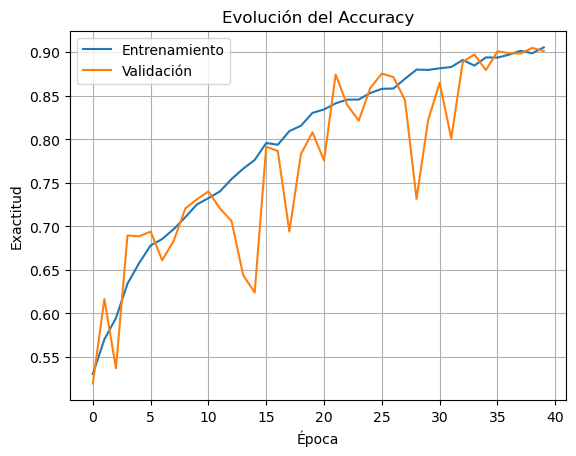

In [44]:
#Evolucion del Accuracy cuando se entrena el modelo con las capas descongeladas
plot_accuracy(history)

##  Generación de Predicciones y Evaluación del Modelo 

<p style="text-align: justify;">Se carg&oacute; el mejor modelo previamente guardado para evaluar su desempe&ntilde;o. A continuaci&oacute;n, se generaron las predicciones sobre el conjunto de prueba en forma de probabilidades. Estas se convirtieron a clases binarias utilizando un umbral de 0.5. Finalmente, se obtuvieron las etiquetas reales del conjunto de prueba para compararlas con las predicciones.</p>

In [45]:
#Cargamos el mejor  Modelo obtenido en el entrenamiento
from keras.models import load_model
best_model = load_model('MiModeloV4.keras')

In [46]:
#Obtenemos la matriz de probabilidades.
y_probs = best_model.predict(test_set, verbose=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 267ms/step


In [47]:
# Umbral por defecto de 0.5
y_pred = (y_probs >= 0.50).astype(int) 

In [48]:
# Esto te da los 0s y 1s reales del test_set
y_true = test_set.classes  

#### Evaluacion del Modelo 

In [49]:
# Principales Metricas Recall, Precision, f-Score
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1000
           1       0.90      0.92      0.91      1000

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.90      2000
weighted avg       0.91      0.91      0.90      2000



<p style="text-align: justify;" data-start="80" data-end="517"><strong>Conclusi&oacute;n</strong>:&nbsp;</p>
<p style="text-align: justify;" data-start="80" data-end="517">El modelo alcanz&oacute; un desempe&ntilde;o equilibrado en ambas clases (perros y gatos), con una precisi&oacute;n y recall cercanos al 90%. El F1-score promedio tambi&eacute;n refleja un buen balance entre precisi&oacute;n y sensibilidad, mostrando que el modelo clasifica correctamente la mayor&iacute;a de las im&aacute;genes en el conjunto de prueba. La exactitud global del 91% confirma la efectividad del modelo para esta tarea de clasificaci&oacute;n binaria con un dataset balanceado.</p>

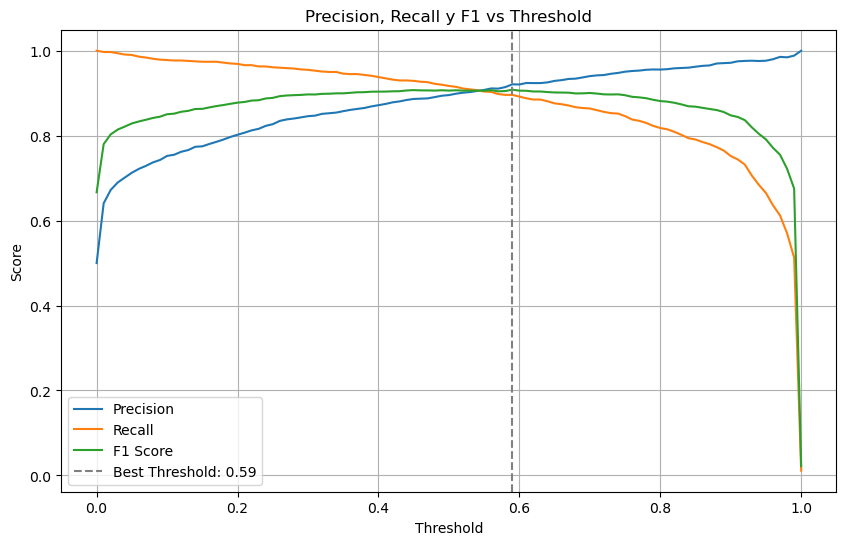

In [50]:
graficar_metricas_vs_threshold(y_probs, y_true)

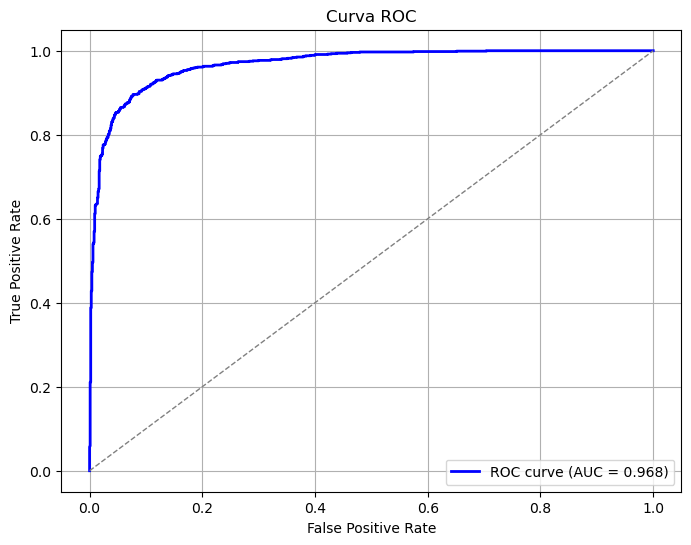

In [57]:
#Curva ROC
plot_roc_curve(y_true, y_probs)

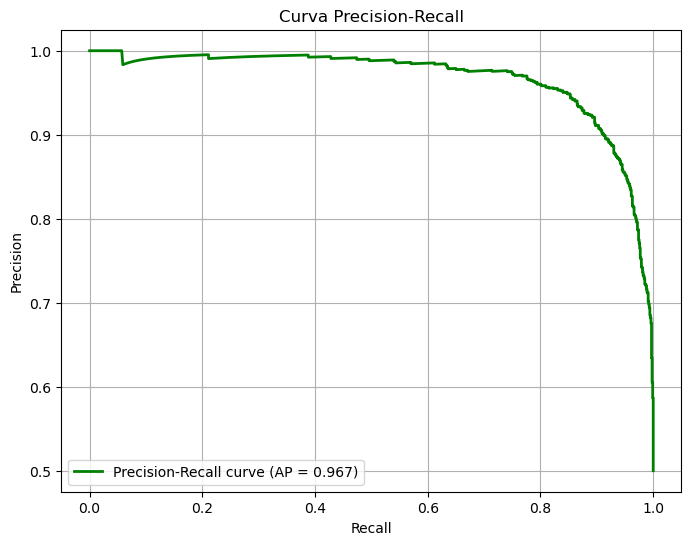

In [58]:
#Curva Precicion - recall
plot_precision_recall_curve(y_true, y_probs)

<p style="text-align: justify;"><strong>Conclusi&oacute;n:</strong></p>
<p style="text-align: justify;">El modelo muestra un desempe&ntilde;o sobresaliente con un &Aacute;rea Bajo la Curva ROC (AUC) del 96.8% y un Average Precision (AP) del 96.7%. Estos resultados indican una excelente capacidad para distinguir correctamente entre las clases positivas y negativas, as&iacute; como un balance &oacute;ptimo entre precisi&oacute;n y recall. En conjunto, estas m&eacute;tricas reflejan que el modelo es altamente efectivo para la tarea de clasificaci&oacute;n en este dataset.</p>

#### Prueba de Fuego 

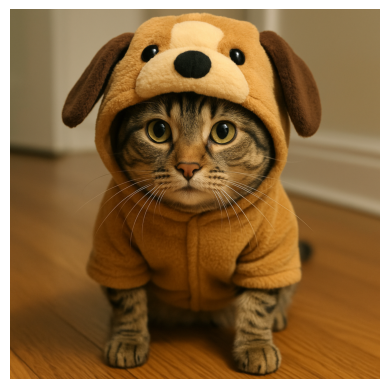

In [61]:
# Cargamos la prueba Individual
img = mpimg.imread('prueba_fuego/gato.png')
plt.imshow(img)
plt.axis('off')  # para quitar los ejes
plt.show()

In [59]:
#Aplicamos el preprocesado a la imagen
img = cargar_preprocesar_imagen("prueba_fuego/gato.png")

In [60]:
# Predecir la imagen
prediction = classifier.predict(img)

#Interpretar resultado
if prediction[0][0] > 0.5:
    print("Predicción: Es un perro")
else:
    print("Predicción: Es un gato")

# Valor de predicción 
print("Valor de predicción :", prediction[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
Predicción: Es un gato
Valor de predicción : [0.0794594]


## Streamlit

<p style="text-align: justify;">Se desarroll&oacute; una aplicaci&oacute;n web interactiva utilizando Streamlit para mostrar los resultados del modelo de clasificaci&oacute;n de im&aacute;genes de perros y gatos. La aplicaci&oacute;n permite al usuario cargar una imagen desde su dispositivo, y el modelo predice la clase correspondiente utilizando una red neuronal convolucional previamente entrenada. La interfaz es sencilla e intuitiva, y sirve como demostraci&oacute;n pr&aacute;ctica del despliegue de modelos de deep learning en producci&oacute;n.</p>

<p><a href="https://pruebasmobilenetv2-fine-tuning.streamlit.app/" target="_blank" rel="noopener">https://pruebasmobilenetv2-fine-tuning.streamlit.app/</a></p>
